In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np


from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from wordcloud import WordCloud

from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [ ]:

#data from Mod3DataCollection.ipynb
dfNews = pd.read_csv('mod3NewsDataFINAL.csv')
dfReddit = pd.read_csv('mod3RedditDataFINAL.csv')

#default engl stop words + the keywords from the queries/labels
StopWordsKeys = ENGLISH_STOP_WORDS.union({
    "art", "AI", "ai", "ART", 'im', 'like', 'midjourney',
})

StopWordsKeys = list(StopWordsKeys)
print(StopWordsKeys)


['whereby', 'somehow', 'anyhow', 'anything', 'inc', 'should', 'as', 'yourself', 'nor', 'others', 'off', 'amoungst', 'if', 'next', 'there', 'itself', 'five', 'few', 'whereas', 'this', 'detail', 'within', 'all', 'might', 'moreover', 'nothing', 'because', 'were', 'four', 'up', 'fifty', 'too', 'perhaps', 'whom', 'here', 'only', 'former', 'whose', 'ours', 'afterwards', 'further', 'get', 'go', 'since', 'whatever', 'about', 'behind', 'nine', 'such', 'most', 'seemed', 'hundred', 'is', 'them', 'what', 'himself', 'thin', 'me', 'yours', 'below', 'still', 'someone', 'back', 'would', 'from', 'while', 'whither', 'thence', 'one', 'con', 'besides', 'around', 'seem', 'DALL-E', 'beside', 'no', 'made', 'through', 'very', 'yet', 'sincere', 'can', 'these', 'at', 'had', 'un', 'its', 'also', 'whoever', 'becoming', 'per', 'ever', 'our', 'do', 'sixty', 'hence', 'alone', 'neither', 'whenever', 'ART', 'sometimes', 'well', 'either', 'first', 'another', 'toward', 'same', 'forty', 'often', 'which', 'several', 'ever

## REDDIT DATA PREP -- CV

In [13]:
def display_confusion_matrix(y_true, y_pred, model_name, model):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap="Blues")
    plt.title(model_name)
    plt.show()

In [14]:
dfReddit.sample(20)

dfReddit['textColumn'] = (
    dfReddit['title'].fillna('') + ' ' +
    dfReddit['description'].fillna('') + ' ' +
    dfReddit['content'].fillna('')
).str.strip()

dfReddit.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   LABEL        426 non-null    object
 1   title        422 non-null    object
 2   description  288 non-null    object
 3   content      267 non-null    object
 4   source       426 non-null    object
 5   textColumn   426 non-null    object
dtypes: object(6)
memory usage: 20.1+ KB


In [15]:

redditTexts  = dfReddit['textColumn'].fillna('').tolist()
redditLabels = dfReddit['LABEL'].tolist()
#pass in a lemmatizer to the CountVectorizer

lemmatizer = WordNetLemmatizer()
def lemmatize_analyzer(text):
    return [lemmatizer.lemmatize(tok) for tok in word_tokenize(text.lower()) if tok.isalpha() and tok not in StopWordsKeys]

#keeping the main dataset with 200 features
countVectorizerReddit200 = CountVectorizer(
    input='content',
    token_pattern=r'\b[a-zA-Z]{3,}\b', #this will keep only words with 3 or more characters
    lowercase=True,
    ngram_range=(1,3),
    stop_words=StopWordsKeys,
    max_features=300,
    max_df=0.1,
)

dtmRedditCV200 = countVectorizerReddit200.fit_transform(redditTexts)
featureNamesRedditCV200 = countVectorizerReddit200.get_feature_names_out()

dfRedditCV200 = pd.DataFrame(dtmRedditCV200.toarray(), columns=featureNamesRedditCV200)
dfRedditCV200.insert(loc=0, column='LABEL', value=redditLabels)

dfRedditCV200.sample(3)

/Users/roryoflynn/Desktop/2025 - SPRING/INFO-5603-TEXTMINING/TXTProject/TextMining/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dall'] not in stop_words.
  warnings.warn(


,LABEL,absolutely,account,actual,add,advice,ago,air,anatomy,android,...,worth,wouldnt,wow,write,wrong,yeah,year,yes,youll,youtube
53,AIart,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AIart,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
92,AIart,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
print(dfRedditCV200.columns.tolist())

['LABEL', 'absolutely', 'account', 'actual', 'add', 'advice', 'ago', 'air', 'anatomy', 'android', 'animation', 'anime', 'app', 'apple', 'apps', 'arent', 'artwork', 'ask', 'away', 'awesome', 'background', 'bad', 'based', 'basic', 'basically', 'beginner', 'believe', 'big', 'book', 'books', 'bought', 'brush', 'brushes', 'budget', 'business', 'buy', 'care', 'case', 'change', 'character', 'cheap', 'check', 'clip', 'clip studio', 'color', 'colors', 'come', 'comes', 'comment', 'comments', 'community', 'companies', 'company', 'completely', 'computer', 'concept', 'consider', 'content', 'copyright', 'course', 'created', 'creating', 'creative', 'creativity', 'currently', 'data', 'days', 'definitely', 'deleted', 'depends', 'design', 'difficult', 'display', 'dont know', 'dont think', 'dont want', 'drawings', 'easier', 'easy', 'edit', 'email', 'end', 'enjoy', 'etsy', 'exactly', 'example', 'expensive', 'experience', 'eyes', 'face', 'fact', 'fan', 'far', 'feels', 'figure', 'file', 'files', 'fit', 'fri

In [17]:
tfidfVectorizerReddit200 = TfidfVectorizer(
    input='content',
    token_pattern=r'\b[a-zA-Z]{3,}\b', #this will keep only words with 3 or more characters
    lowercase=True,
    ngram_range=(1,3),
    stop_words=StopWordsKeys,
    max_features=200,
    max_df=0.1,
)

dtmRedditTF200 = tfidfVectorizerReddit200.fit_transform(redditTexts)
featureNamesRedditTF200 = tfidfVectorizerReddit200.get_feature_names_out()

dfRedditTF200 = pd.DataFrame(dtmRedditTF200.toarray(), columns=featureNamesRedditTF200)
dfRedditTF200.insert(loc=0, column='LABEL', value=redditLabels)

dfRedditTF200.sample(3)

/Users/roryoflynn/Desktop/2025 - SPRING/INFO-5603-TEXTMINING/TXTProject/TextMining/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dall'] not in stop_words.
  warnings.warn(


,LABEL,absolutely,actual,add,advice,ago,air,android,app,apple,...,world,worth,wouldnt,wow,wrong,yeah,year,yes,youll,youtube
175,art,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
265,AIart,0.0,0.0,0.0,0.0,0.288609,0.0,0.251227,0.0,0.0,...,0.0,0.31311,0.0,0.0,0.0,0.0,0.182387,0.0,0.0,0.0
238,AIart,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [18]:
print(dfRedditTF200.columns.tolist())

['LABEL', 'absolutely', 'actual', 'add', 'advice', 'ago', 'air', 'android', 'app', 'apple', 'apps', 'arent', 'artwork', 'ask', 'away', 'awesome', 'background', 'bad', 'based', 'basically', 'believe', 'big', 'book', 'books', 'brush', 'business', 'buy', 'change', 'cheap', 'check', 'color', 'colors', 'come', 'comes', 'comment', 'companies', 'completely', 'concept', 'content', 'copyright', 'course', 'created', 'creative', 'currently', 'data', 'days', 'definitely', 'deleted', 'design', 'difficult', 'dont know', 'easier', 'easy', 'end', 'enjoy', 'example', 'experience', 'face', 'fact', 'far', 'feels', 'fun', 'future', 'game', 'general', 'hand', 'hello', 'honestly', 'hope', 'hours', 'huion', 'human', 'ill', 'image', 'images', 'important', 'instead', 'ipad', 'issue', 'ive seen', 'jobs', 'kinda', 'krita', 'large', 'learn', 'learning', 'left', 'let', 'level', 'life', 'light', 'line', 'link', 'literally', 'living', 'lol', 'make sure', 'market', 'matter', 'media', 'mind', 'model', 'ones', 'online'

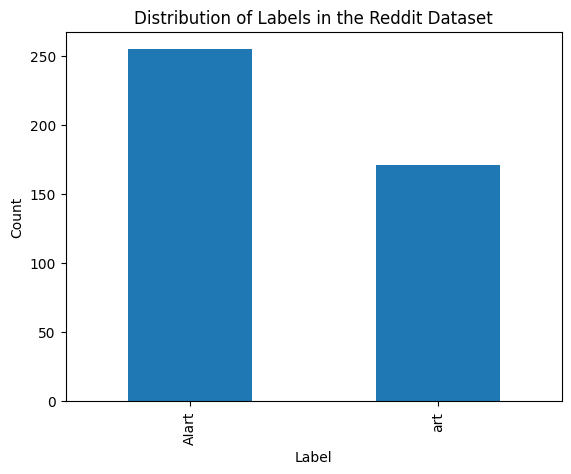

In [19]:
dfRedditCV200['LABEL'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels in the Reddit Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## REDDIT NAIVE BAYES

[[59 23]
 [14 32]]
              precision    recall  f1-score   support

       AIart       0.81      0.72      0.76        82
         art       0.58      0.70      0.63        46

    accuracy                           0.71       128
   macro avg       0.70      0.71      0.70       128
weighted avg       0.73      0.71      0.72       128



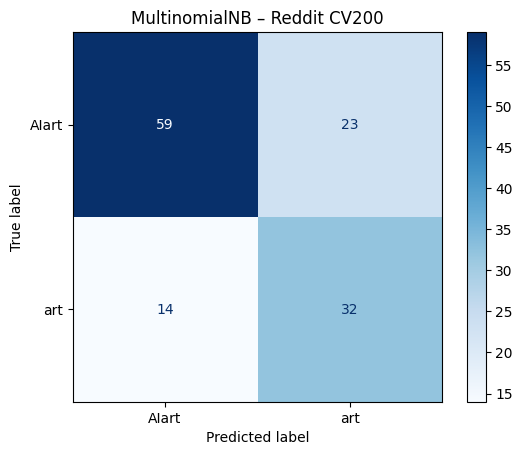

In [57]:
# ok so max features is absolutely the way to go because the words are barely common at all.
## REDDIT COUNT VECTORIZED
X1 = dfRedditCV200.drop('LABEL', axis=1)
Y1 = dfRedditCV200['LABEL']

XTrain1, XTest1, YTrain1, YTest1 = train_test_split(
    X1, Y1,
    test_size=0.3,
    random_state=42,
)


nb1 = MultinomialNB()
nb1.fit(XTrain1, YTrain1)
YPred1 = nb1.predict(XTest1)
prob1  = nb1.predict_proba(XTest1).round(3)

cm1 = confusion_matrix(YTest1, YPred1)
print(cm1)
print(classification_report(YTest1, YPred1))
display_confusion_matrix(YTest1, YPred1, "MultinomialNB – Reddit CV200", nb1)

#77


In [58]:

# ##TUNENEEEE
# param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

# mnb = MultinomialNB()
# grid_search = GridSearchCV(mnb, param_grid, cv=5)
# grid_search.fit(XTrain1, YTrain1)

# best_mnb = grid_search.best_estimator_
# YPred  = best_mnb.predict(XTest1)

# best_alpha = grid_search.best_params_['alpha']
# nb_tuned = MultinomialNB(alpha=best_alpha)

# nb_tuned.fit(XTrain1, YTrain1)
# YPred_tuned = nb_tuned.predict(XTest1)
# #barely changed lol alpha was alr there
# print(confusion_matrix(YTest1, YPred_tuned))
# print(classification_report(YTest1, YPred_tuned))
# display_confusion_matrix(YTest1, YPred_tuned, "MultinomialNB – Reddit CV200", nb1)

# #77%

{'alpha': 0.1}


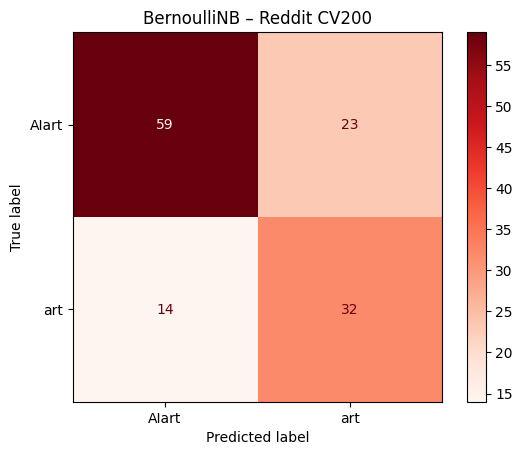

[[59 23]
 [14 32]]
              precision    recall  f1-score   support

       AIart       0.81      0.72      0.76        82
         art       0.58      0.70      0.63        46

    accuracy                           0.71       128
   macro avg       0.70      0.71      0.70       128
weighted avg       0.73      0.71      0.72       128



In [59]:
def display_confusion_matrixHATE(y_true, y_pred, model_name, model):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap="Reds")
    plt.title(model_name)
    plt.show()

param_grid = {
    'alpha':    [0.1, 0.5, 1.0, 2.0],
}

bnb = BernoulliNB()
grid_search = GridSearchCV(bnb, param_grid, cv=5)
grid_search.fit(XTrain1, YTrain1)

best_bnb = grid_search.best_estimator_
print(grid_search.best_params_)
##LOL nevermind

display_confusion_matrixHATE(YTest1, YPred1, "BernoulliNB – Reddit CV200", best_bnb)
print(confusion_matrix(YTest1, YPred1))
print(classification_report(YTest1, YPred1))

# 77 % of posts are classified correctly.

In [ ]:
## NOW TO TFIDF 200 FEATURES

In [ ]:
# # REDDIT TFIDF
# X2 = dfRedditTF200.drop('LABEL', axis=1)
# Y2 = dfRedditTF200['LABEL']

# XTrain2, XTest2, YTrain2, YTest2 = train_test_split(
#     X2, Y2,
#     test_size=0.3,
#     random_state=42,
# )

# nb2 = MultinomialNB()
# nb2.fit(XTrain2, YTrain2)
# YPred2 = nb2.predict(XTest2)
# prob2  = nb2.predict_proba(XTest2).round(3)

# cm2 = confusion_matrix(YTest2, YPred2)
# print(cm2)

# #this one had a lof of art labeled AI Art... (is this a false positive or a false negative?)
# print(classification_report(YTest2, YPred2))

# display_confusion_matrix(YTest2, YPred2, "MultinomialNB – Reddit TFIDF200", nb2)


In [ ]:
## OK TRYING TO CHANGE THE DATA FIRST:

dfReddit = pd.read_csv('mod3RedditDataFINAL.csv')

reddit_texts = dfReddit['content'].fillna('').tolist()
reddit_labels = dfReddit['LABEL'].tolist()


countVectorizerReddit350 = CountVectorizer(
    input='content',
    lowercase=True,
    stop_words=StopWordsKeys,
    ngram_range=(1, 3),
    min_df=3,
    max_features=350
)

dtmRedditCV350 = countVectorizerReddit350.fit_transform(reddit_texts)
featureNamesRedditCV350 = countVectorizerReddit350.get_feature_names_out()


dfRedditCV350 = pd.DataFrame(dtmRedditCV350.toarray(), columns=featureNamesRedditCV350)
dfRedditCV350.insert(loc=0, column='LABEL', value=reddit_labels)
print(dfRedditCV350.sample(3))

In [ ]:

## REDDIT COUNT VECTORIZED
X1 = dfRedditCV350.drop('LABEL', axis=1)
Y1 = dfRedditCV350['LABEL']

XTrain1, XTest1, YTrain1, YTest1 = train_test_split(
    X1, Y1,
    test_size=0.3,
    random_state=42,
)

nb1 = MultinomialNB()
nb1.fit(XTrain1, YTrain1)
YPred1 = nb1.predict(XTest1)
prob1  = nb1.predict_proba(XTest1).round(3)

cm1 = confusion_matrix(YTest1, YPred1)
print(cm1)
print(classification_report(YTest1, YPred1))
display_confusion_matrix(YTest1, YPred1, "MultinomialNB – Reddit CV200", nb1)

#77


In [ ]:
X_bal = dfRedditCV350.drop('LABEL', axis=1)
y_bal = dfRedditCV350['LABEL']

XTrain_bal, XTest_bal, YTrain_bal, YTest_bal = train_test_split(
    X_bal, y_bal,
    test_size=0.3,
    random_state=42,
    stratify=y_bal
)

class_counts = YTrain_bal.value_counts()
total_samples = len(YTrain_bal)
weights_map = {
    'AIart': total_samples / (2 * class_counts['AIart']),
    'art':   total_samples / (2 * class_counts['art'])
}
sample_weights = YTrain_bal.map(weights_map)

nb1 = MultinomialNB()
nb1.fit(XTrain_bal, YTrain_bal, sample_weight=sample_weights)

YPred1 = nb1.predict(XTest_bal)
prob1  = nb1.predict_proba(XTest_bal)

print(confusion_matrix(YTest_bal, YPred1))
print(classification_report(YTest_bal, YPred1))

display_confusion_matrixHATE(
    YTest_bal,
    YPred1,
    "MultinomialNB – Reddit CV200 (Weighted)",
    nb1
)


In [ ]:
X = dfRedditCV200.drop('LABEL', axis=1)
y = dfRedditCV200['LABEL']

## NEWS DATA PREP -- CV 


In [20]:
dfNews = pd.read_csv('mod3NewsDataFINAL.csv')
len(dfNews)

197

In [21]:
## NEWS
news_texts  = dfNews['cleanedContent'].fillna('').tolist()
news_labels = dfNews['LABEL'].tolist()

countVectorizerNews200 = CountVectorizer(
    input='content',
    token_pattern=r'\b[a-zA-Z]{3,}\b', #this will keep only words with 3 or more characters
    lowercase=True,
    ngram_range=(1,3),
    stop_words=StopWordsKeys,
    max_df=0.1,
    max_features=200,
)

dtmNewsCV200 = countVectorizerNews200.fit_transform(news_texts)
featureNamesNewsCV200 = countVectorizerNews200.get_feature_names_out()
# i should've made a function jesusss

dfNewsCV200 = pd.DataFrame(dtmNewsCV200.toarray(), columns=featureNamesNewsCV200)
dfNewsCV200.insert(loc=0, column='LABEL', value=news_labels)

# print(dfNewsCV200.columns.tolist())

/Users/roryoflynn/Desktop/2025 - SPRING/INFO-5603-TEXTMINING/TXTProject/TextMining/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dall'] not in stop_words.
  warnings.warn(


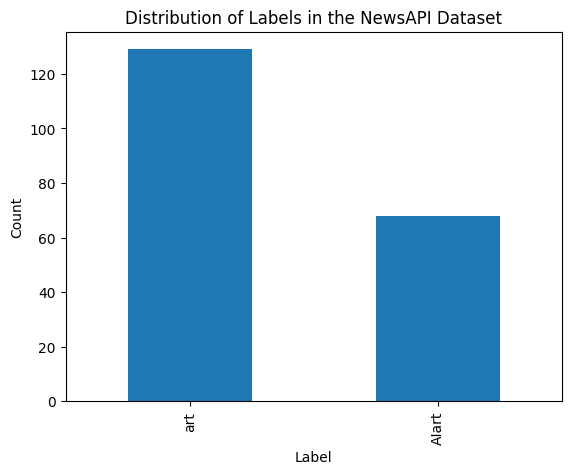

In [23]:
dfNewsCV200['LABEL'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels in the NewsAPI Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

[[24  2]
 [ 7 27]]
              precision    recall  f1-score   support

       AIart       0.77      0.92      0.84        26
         art       0.93      0.79      0.86        34

    accuracy                           0.85        60
   macro avg       0.85      0.86      0.85        60
weighted avg       0.86      0.85      0.85        60



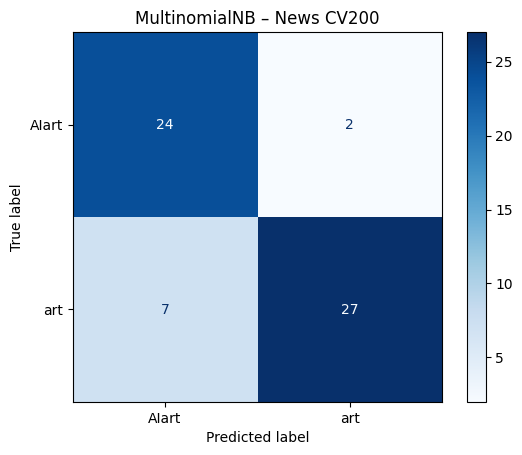

In [41]:

X1 = dfNewsCV200.drop('LABEL', axis=1)
Y1 = dfNewsCV200['LABEL']

XTrain1, XTest1, YTrain1, YTest1 = train_test_split(
    X1, Y1,
    test_size=0.3, #around 55 tests
    random_state=12,
)


nb1 = MultinomialNB()
nb1.fit(XTrain1, YTrain1)

YPred1 = nb1.predict(XTest1)
prob1  = nb1.predict_proba(XTest1).round(3)

cm1 = confusion_matrix(YTest1, YPred1)
print(cm1)
print(classification_report(YTest1, YPred1))
display_confusion_matrix(YTest1, YPred1, "MultinomialNB – News CV200", nb1)

#77


In [44]:
print(dfNewsCV200.columns.tolist())

['LABEL', 'abstract', 'addition', 'adobe', 'aesthetic', 'altman', 'amuse', 'angeles', 'animals', 'anime', 'apple', 'architects', 'architecture', 'article', 'background', 'bbc', 'beauty', 'bfa', 'body', 'books', 'break', 'british', 'buildings', 'challenges', 'chappe', 'children', 'china', 'code', 'comment', 'companies', 'context', 'courtesy', 'cover', 'credit', 'cultural', 'custom', 'dall', 'deal', 'designers', 'detailed', 'developers', 'development', 'device', 'devices', 'dezeen', 'draft', 'draft mode', 'drawings', 'edition', 'entry', 'event', 'events', 'exhibitions', 'experiences', 'external', 'facebook', 'famous', 'fantastic', 'faster', 'federal', 'figure', 'file', 'florida', 'founder', 'furniture', 'galleries', 'garden', 'garwood', 'generative', 'generator', 'ghibli', 'google', 'graphic design', 'hannah', 'hannah lock', 'herbie', 'highwaymen', 'hostinger', 'image credit', 'image generation', 'image generator', 'information', 'intelligence', 'iphone', 'jobs', 'language', 'learning', 

## COMBINED DATASET 

In [40]:
dfReddit['textColumn'] = (
    dfReddit['title'].fillna('') + ' ' +
    dfReddit['description'].fillna('') + ' ' +
    dfReddit['content'].fillna('')
).str.strip()


dfReddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   LABEL        426 non-null    object
 1   title        422 non-null    object
 2   description  288 non-null    object
 3   content      267 non-null    object
 4   source       426 non-null    object
 5   textColumn   426 non-null    object
dtypes: object(6)
memory usage: 20.1+ KB


In [41]:
dfNews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   LABEL               197 non-null    object
 1   newsApiContent      197 non-null    object
 2   fullArticleContent  197 non-null    object
 3   cleanedContent      197 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


In [24]:
newsSubset = dfNews[['LABEL', 'cleanedContent']].rename(columns={'cleanedContent': 'text'})
redditSubset = dfReddit[['LABEL', 'textColumn']].rename(columns={'textColumn': 'text'})


newsSubset['text'] = newsSubset['text'].fillna('')
redditSubset['text'] = redditSubset['text'].fillna('')

# Combine the two datasets
combinedTextData = pd.concat([newsSubset, redditSubset], ignore_index=True)
combinedTextData.info()
combinedTextData.to_csv('combinedTextData.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   LABEL   623 non-null    object
 1   text    623 non-null    object
dtypes: object(2)
memory usage: 9.9+ KB


In [82]:
combinedTextData.head(10)

,LABEL,text
0,AIart,Call of Duty fans speculate what Season could ...
1,AIart,The first trailer for Marvel s upcoming Fantas...
2,AIart,No Siri data has ever been used for marketing ...
3,AIart,This unusual tattoo hack by Emily The Engineer...
4,AIart,This article is part of Gizmodo Deals produced...
5,AIart,Buried in a talk on AI from an artist who is d...
6,AIart,This article is part of Gizmodo Deals produced...
7,AIart,This article is part of Gizmodo Deals produced...
8,AIart,By Glenn Garner Associate Editor As another wi...
9,AIart,Peter Kafka Chief Correspondent covering media...


In [ ]:

texts  = combinedTextData['text'].fillna('').tolist()
labels = combinedTextData['LABEL'].tolist()

countVectorizer200 = CountVectorizer(
    input='content',
    token_pattern=r'\b[a-zA-Z]{3,}\b', #this will keep only words with 3 or more characters
    lowercase=True,
    ngram_range=(1,4), # pick up more phrases
    stop_words=StopWordsKeys,
    max_features=300,
    max_df=0.1,
)

dtmCV200 = countVectorizer200.fit_transform(texts)
featureNamesCV200 = countVectorizer200.get_feature_names_out()

dfCV200 = pd.DataFrame(dtmCV200.toarray(), columns=featureNamesCV200)
dfCV200.insert(loc=0, column='LABEL', value=labels)

print(dfCV200.columns.tolist())

/Users/roryoflynn/Desktop/2025 - SPRING/INFO-5603-TEXTMINING/TXTProject/TextMining/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dall'] not in stop_words.
  warnings.warn(


['LABEL', 'according', 'account', 'actual', 'add', 'advice', 'ago', 'american', 'animation', 'anime', 'app', 'apple', 'apps', 'architecture', 'artist', 'artistic', 'arts', 'artwork', 'ask', 'background', 'bad', 'believe', 'black', 'blue', 'book', 'books', 'build', 'building', 'business', 'called', 'came', 'case', 'change', 'chappe', 'character', 'characters', 'chatgpt', 'children', 'city', 'collection', 'colors', 'com', 'comes', 'comment', 'comments', 'community', 'companies', 'company', 'concept', 'contemporary', 'copyright', 'cost', 'course', 'creating', 'creation', 'creativity', 'culture', 'current', 'currently', 'daily', 'dall', 'data', 'definitely', 'details', 'dezeen', 'didn', 'didnt', 'display', 'doesn', 'drawings', 'early', 'earn', 'easy', 'elements', 'email', 'events', 'exhibition', 'explore', 'face', 'fact', 'family', 'feature', 'feels', 'figure', 'file', 'final', 'focus', 'follow', 'form', 'fun', 'gallery', 'game', 'garwood', 'general', 'generate', 'generated', 'generation',

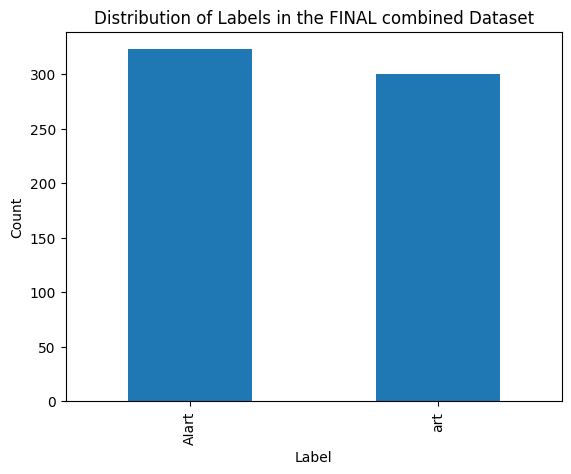

LABEL
AIart    323
art      300
Name: count, dtype: int64


In [38]:
dfCV200['LABEL'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels in the FINAL combined Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()
print(dfCV200['LABEL'].value_counts())


In [10]:
dfCV200.to_csv('mod3CountVectorizedData.csv')

In [83]:
dfCV200.head(10)

,LABEL,according,account,actual,add,advice,ago,american,animation,anime,...,ways,website,week,white,women,worked,worth,wrong,yes,youtube
0,AIart,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AIart,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AIart,0,0,0,0,0,5,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,AIart,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
4,AIart,0,0,0,0,0,0,0,0,0,...,0,13,0,0,0,0,0,0,0,0
5,AIart,0,0,1,0,0,1,0,0,0,...,2,1,1,0,0,0,2,1,2,2
6,AIart,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,AIart,0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,0,0,0
8,AIart,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,AIart,0,0,0,0,0,0,1,0,0,...,0,0,1,2,0,0,1,0,1,0


## COMBINED DATASET -- NAIVE BAYES

[[86 14]
 [23 64]]
              precision    recall  f1-score   support

       AIart       0.79      0.86      0.82       100
         art       0.82      0.74      0.78        87

    accuracy                           0.80       187
   macro avg       0.80      0.80      0.80       187
weighted avg       0.80      0.80      0.80       187



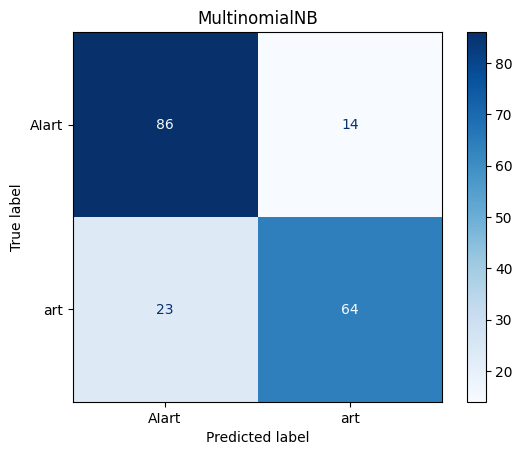

In [26]:

X1 = dfCV200.drop('LABEL', axis=1)
Y1 = dfCV200['LABEL']

XTrain1, XTest1, YTrain1, YTest1 = train_test_split(
    X1, Y1,
    test_size=0.3,
    random_state=42,
)

nb1 = MultinomialNB()
nb1.fit(XTrain1, YTrain1)
YPred1 = nb1.predict(XTest1)
prob1  = nb1.predict_proba(XTest1).round(3)

cm1 = confusion_matrix(YTest1, YPred1)
print(cm1)
print(classification_report(YTest1, YPred1))
display_confusion_matrix(YTest1, YPred1, "MultinomialNB", nb1)

#77


In [27]:
XTrain1.to_csv('XTrain1.csv', index=False)


XTest1.to_csv('XTest1.csv', index=False)


In [35]:
print(len(XTrain1))
XTrain1.head(5)

436


,according,account,actual,add,advice,ago,american,animation,anime,app,...,ways,website,week,white,women,worked,worth,wrong,yes,youtube
412,0,0,0,0,0,0,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0
437,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
33,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
print(len(XTest1))
XTest1.head(5)

187


,according,account,actual,add,advice,ago,american,animation,anime,app,...,ways,website,week,white,women,worked,worth,wrong,yes,youtube
249,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
558,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110,0,2,0,0,0,0,0,2,1,0,...,0,0,1,1,0,0,2,0,0,0


{'alpha': 0.1}


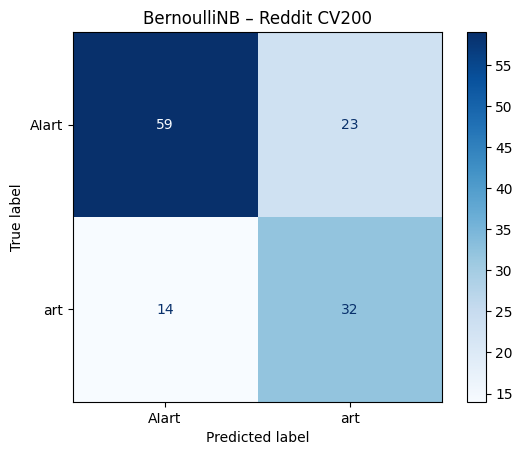

[[59 23]
 [14 32]]
              precision    recall  f1-score   support

       AIart       0.81      0.72      0.76        82
         art       0.58      0.70      0.63        46

    accuracy                           0.71       128
   macro avg       0.70      0.71      0.70       128
weighted avg       0.73      0.71      0.72       128



In [ ]:
#BernoulliNB

param_grid = {
    'alpha':    [0.1, 0.5, 1.0, 2.0],
}

bnb = BernoulliNB()
grid_search = GridSearchCV(bnb, param_grid, cv=5)
grid_search.fit(XTrain1, YTrain1)

best_bnb = grid_search.best_estimator_
print(grid_search.best_params_)
##LOL nevermind

display_confusion_matrix(YTest1, YPred1, "BernoulliNB – CV200", best_bnb)
print(confusion_matrix(YTest1, YPred1))
print(classification_report(YTest1, YPred1))

# 77 % of posts are classified correctly.

# DECISION TREES

              precision    recall  f1-score   support

       AIart       0.74      0.64      0.69       100
         art       0.64      0.75      0.69        87

    accuracy                           0.69       187
   macro avg       0.69      0.69      0.69       187
weighted avg       0.70      0.69      0.69       187



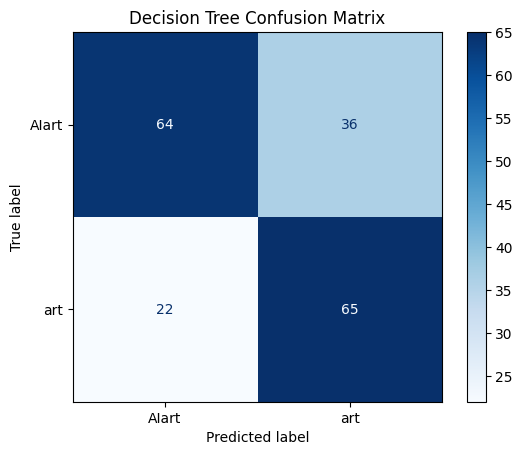

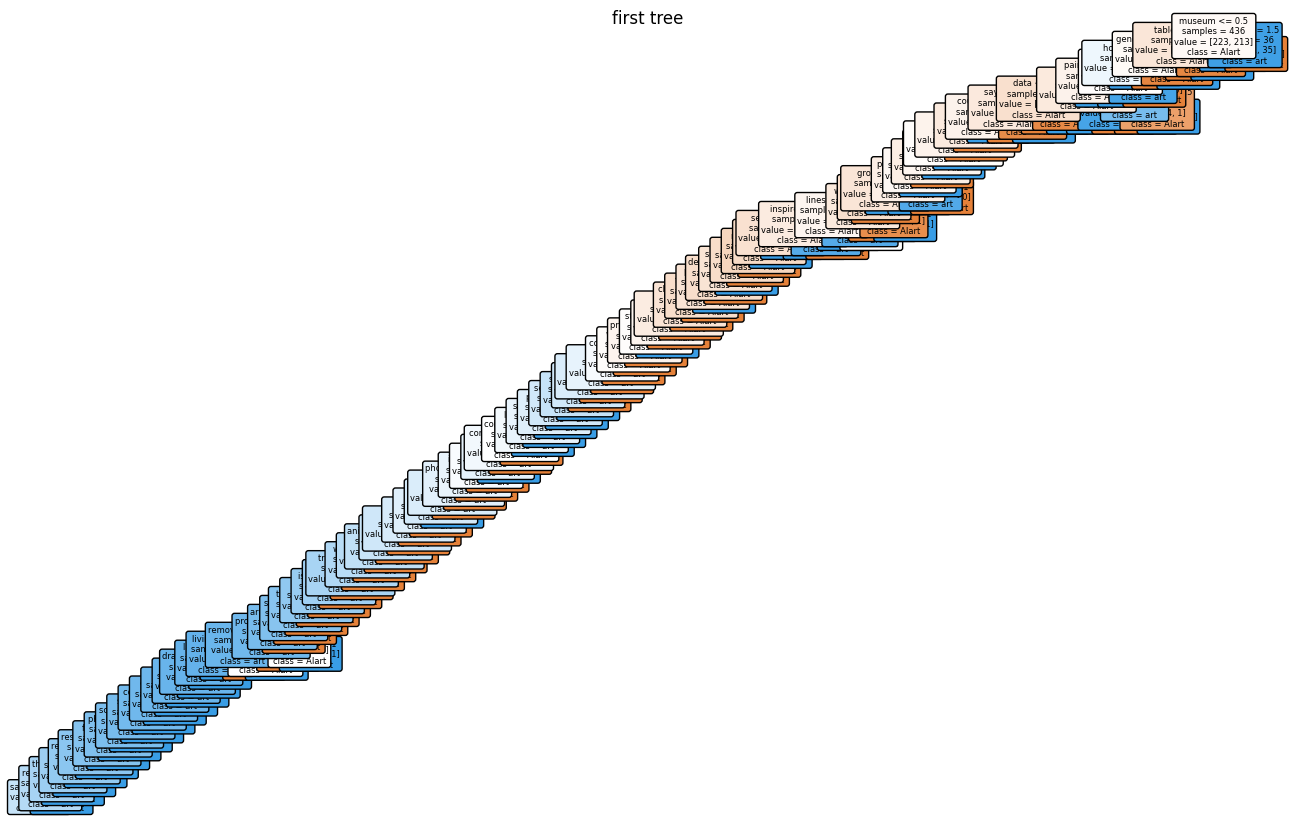

In [ ]:

X = dfCV200.drop('LABEL', axis=1)
Y = dfCV200['LABEL']

# 70% train 30% test
XTrain, XTest, YTrain, YTest = train_test_split(
    X, Y,
    test_size=0.3,
    random_state=42,
)

#train the tree
dt = DecisionTreeClassifier( random_state=42)
dt.fit(XTrain, YTrain)

YPred = dt.predict(XTest)

cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(YTest, YPred), display_labels=dt.classes_)
print(classification_report(YTest, YPred))

display_confusion_matrix(YTest, YPred, "Decision Tree Confusion Matrix", nb1)

fig_tree, ax_tree = plt.subplots(figsize=(16, 10))
plot_tree(
    dt,
    feature_names=X.columns,
    class_names=dt.classes_,
    filled=True,
    impurity=False,
    rounded=True,
    fontsize=6,
    ax=ax_tree
)
ax_tree.set_title("first tree")
plt.show()


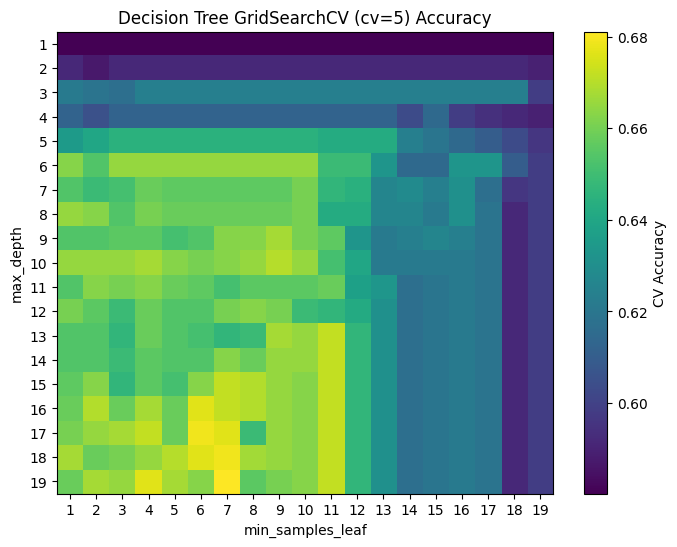

Best CV Accuracy: 0.681(max_depth=19, min_samples_leaf=7)


In [ ]:
# ok grid search bc i thought i really could tune this up

X = dfCV200.drop('LABEL', axis=1)
Y = dfCV200['LABEL']
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.3, random_state=42)


param_grid = {
    'max_depth': range(1, 20),
    'min_samples_leaf': range(1, 20),
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=False
)
grid.fit(XTrain, YTrain)


mean_scores = grid.cv_results_['mean_test_score']
scores_matrix = mean_scores.reshape(len(param_grid['max_depth']), len(param_grid['min_samples_leaf']))


best_idx = np.unravel_index(scores_matrix.argmax(), scores_matrix.shape)
best_depth = param_grid['max_depth'][best_idx[0]]
best_leaf = param_grid['min_samples_leaf'][best_idx[1]]
best_score = scores_matrix[best_idx]

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(scores_matrix, aspect='auto', cmap='viridis')
cbar = plt.colorbar(im, ax=ax, label='CV Accuracy')


ax.set_xticks(np.arange(len(param_grid['min_samples_leaf'])))
ax.set_yticks(np.arange(len(param_grid['max_depth'])))


ax.set_xticklabels(param_grid['min_samples_leaf'])
ax.set_yticklabels(param_grid['max_depth'])


ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('max_depth')
ax.set_title('Decision Tree GridSearchCV (cv=5) Accuracy')

plt.show()
print(f"Best CV Accuracy: {best_score:.3f}" f"(max_depth={best_depth}, min_samples_leaf={best_leaf})")

              precision    recall  f1-score   support

       AIart       0.64      0.87      0.74       100
         art       0.75      0.44      0.55        87

    accuracy                           0.67       187
   macro avg       0.69      0.65      0.64       187
weighted avg       0.69      0.67      0.65       187



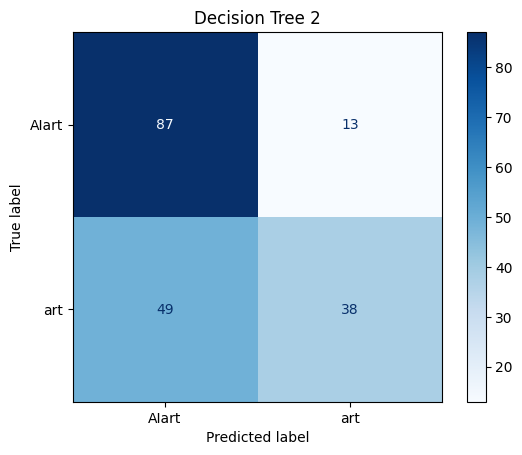

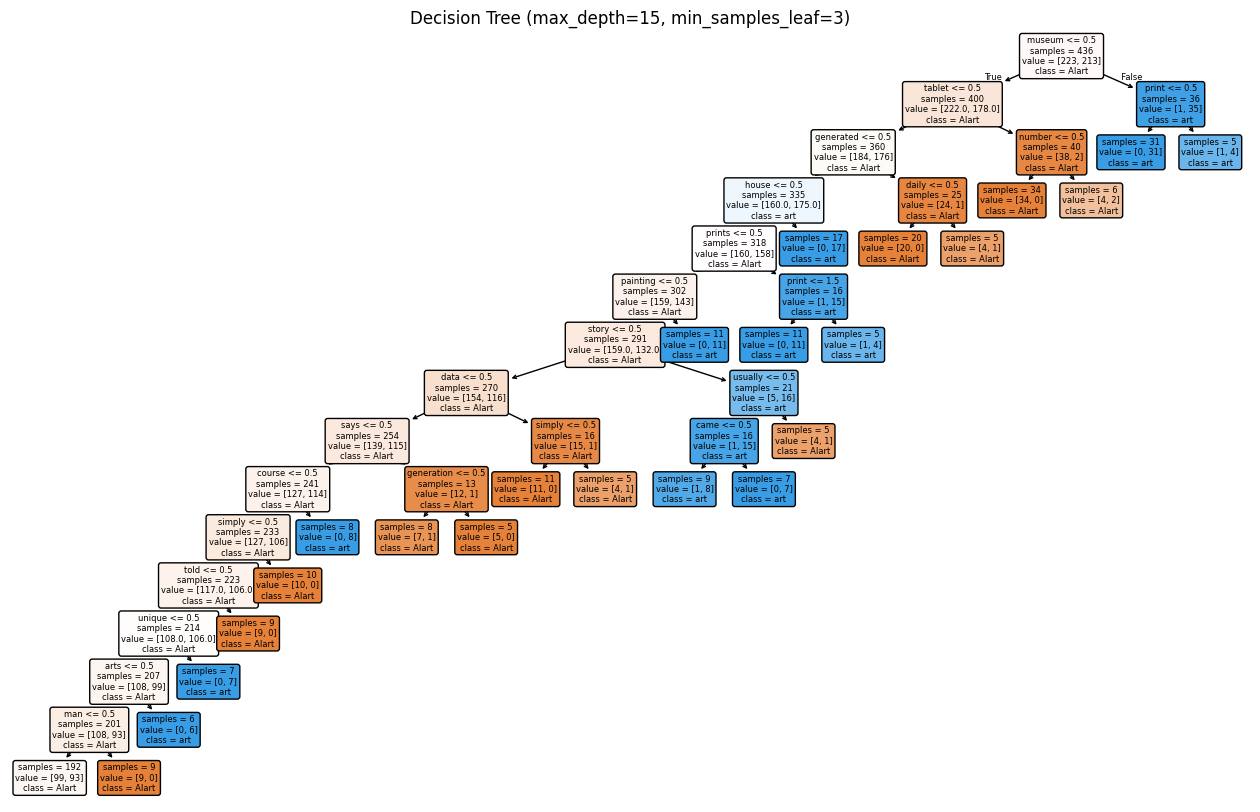

In [ ]:
XTrain, XTest, YTrain, YTest = train_test_split(
    X, Y,
    test_size=0.3,
    random_state=42,
)

#train the tree
dt = DecisionTreeClassifier( random_state=42)
dt.fit(XTrain, YTrain)

YPred = dt.predict(XTest)


YPred = dt.predict(XTest)
print(classification_report(YTest, YPred))


display_confusion_matrix( YTest, YPred, "Decision Tree 2", nb1)

fig_tree, ax_tree = plt.subplots(figsize=(16, 10))
plot_tree(
    dt,
    feature_names=X.columns,
    class_names=dt.classes_,
    filled=True,
    impurity=False,
    rounded=True,
    fontsize=6,
    ax=ax_tree
)
ax_tree.set_title("Decision Tree (max_depth=15, min_samples_leaf=3)")
plt.show()


              precision    recall  f1-score   support

       AIart       0.64      0.87      0.74       100
         art       0.75      0.44      0.55        87

    accuracy                           0.67       187
   macro avg       0.69      0.65      0.64       187
weighted avg       0.69      0.67      0.65       187



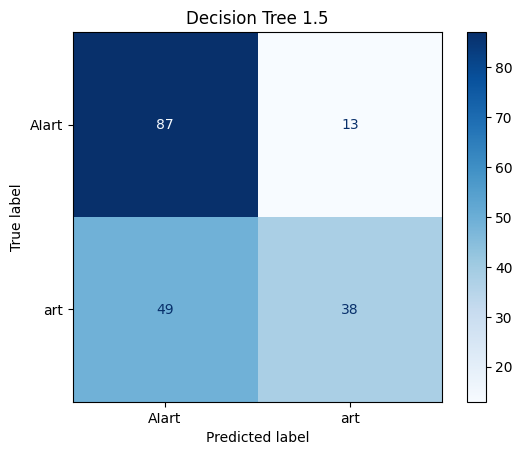

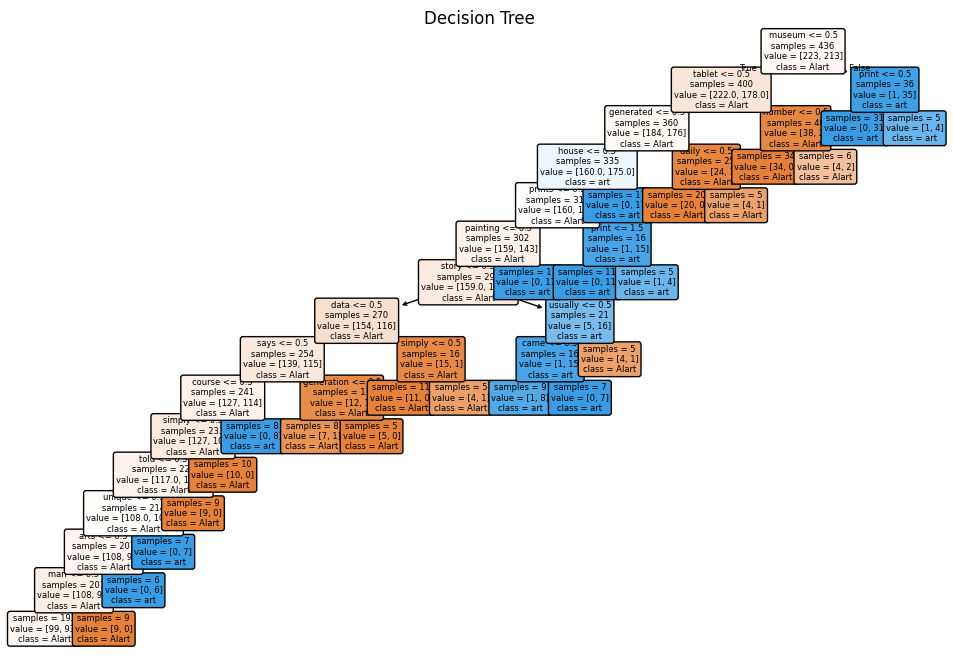

In [68]:
print(classification_report(YTest, YPred))


display_confusion_matrix( YTest, YPred, "Decision Tree 1.5", nb1)
#plot itttt
fig_tree, ax_tree = plt.subplots(figsize=(12, 8))
plot_tree(
    dt,
    feature_names=X.columns,
    class_names=dt.classes_,
    filled=True,
    rounded=True,
    impurity=False,
    fontsize=6,
    ax=ax_tree
)
ax_tree.set_title("Decision Tree")
plt.show()


              precision    recall  f1-score   support

       AIart       0.66      0.80      0.72       100
         art       0.70      0.53      0.60        87

    accuracy                           0.67       187
   macro avg       0.68      0.66      0.66       187
weighted avg       0.68      0.67      0.67       187



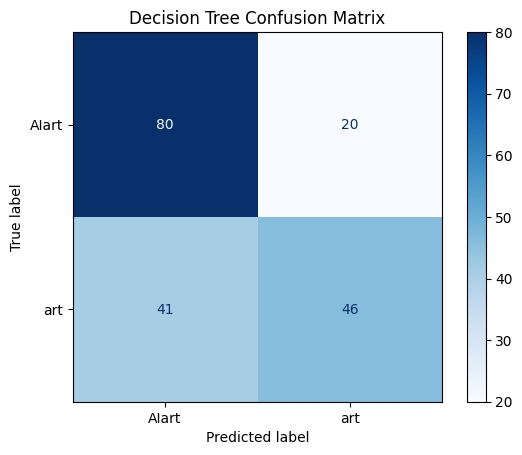

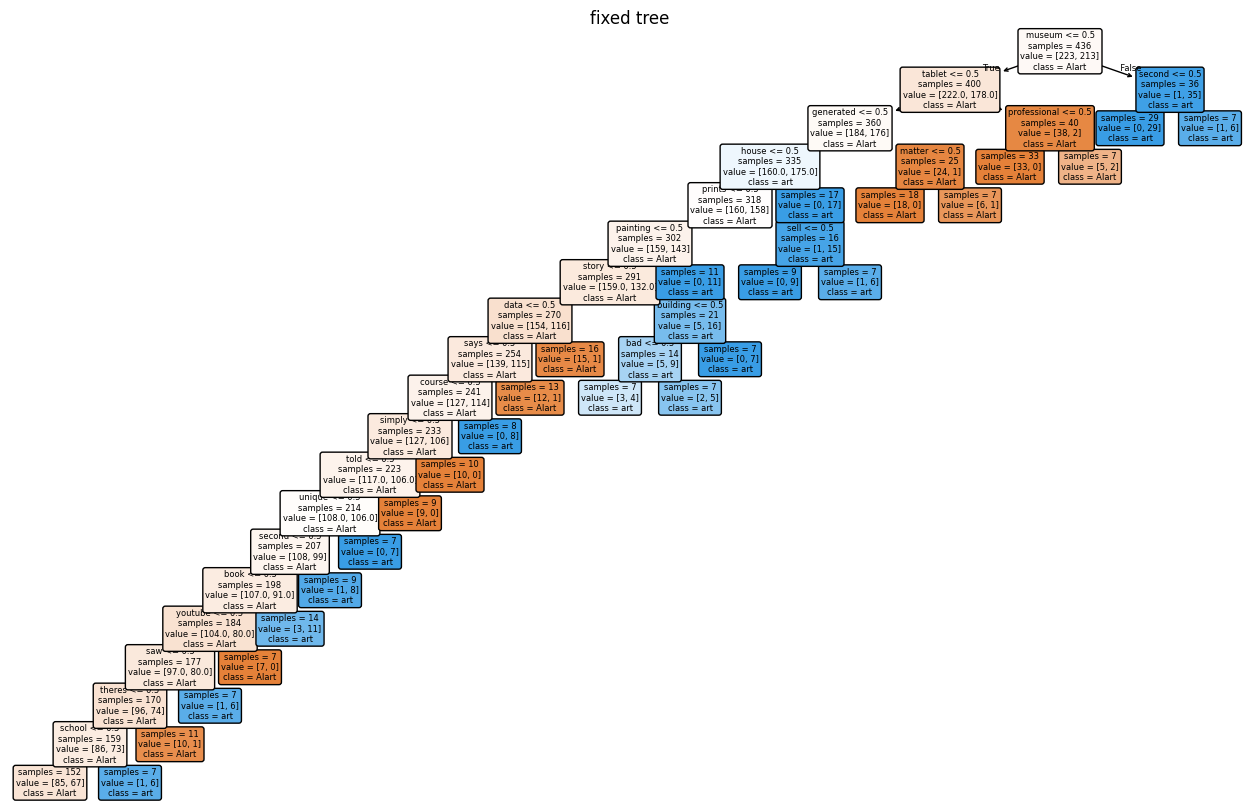

In [125]:

X = dfCV200.drop('LABEL', axis=1)
Y = dfCV200['LABEL']

# 70% train 30% test
XTrain, XTest, YTrain, YTest = train_test_split(
    X, Y,
    test_size=0.3,
    random_state=42,
)

#train the tree with new stuff
dt = DecisionTreeClassifier(
    random_state=42,
    max_depth=19,
    min_samples_leaf=7,
)
dt.fit(XTrain, YTrain)

YPred = dt.predict(XTest)

cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(YTest, YPred), display_labels=dt.classes_)
print(classification_report(YTest, YPred))

display_confusion_matrix(YTest, YPred, "Decision Tree Confusion Matrix", nb1)

fig_tree, ax_tree = plt.subplots(figsize=(16, 10))
plot_tree(
    dt,
    feature_names=X.columns,
    class_names=dt.classes_,
    filled=True,
    impurity=False,
    rounded=True,
    fontsize=6,
    ax=ax_tree
)
ax_tree.set_title("fixed tree")
plt.show()


In [54]:

print("Train acc:", dt_small.score(XTrain, YTrain))
print("Test acc: ", dt_small.score(XTest, YTest))

Train acc: 0.6376146788990825
Test acc:  0.6310160427807486


## SVM 

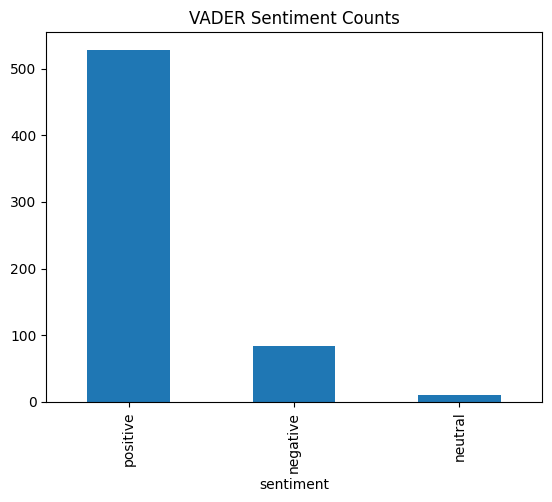

AIart positive: 253
AIart negative: 66
art positive: 275
art negative: 18


In [ ]:


from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

df_v = combinedTextData.copy()

#get scores
df_v['sentiment_score'] = df_v['text'].apply(lambda t: sia.polarity_scores(t)['compound'])

#i picked .07 just bc thats what I remember liking last time I played with Vader...
df_v['sentiment'] = df_v['sentiment_score'].apply(lambda s: 'positive' if s >= 0.07 else ('negative' if s <= -0.07 else 'neutral'))



df_v['sentiment'].value_counts().plot(kind='bar', title='VADER Sentiment Counts')
plt.show()

cross = df_v[df_v['sentiment']!='neutral']\
    .groupby(['LABEL','sentiment']).size().unstack(fill_value=0)
print("AIart positive:", cross.loc['AIart','positive'])
print("AIart negative:", cross.loc['AIart','negative'])
print("art positive:",   cross.loc['art','positive'])
print("art negative:",   cross.loc['art','negative'])


In [ ]:
#bye bye neuts
df_sent = df_v[df_v['sentiment'] != 'neutral'].copy()

texts  = df_sent['text'].fillna('').tolist()
labels = df_sent['sentiment'].tolist()

countVectorizer200 = CountVectorizer(
    input='content',
    token_pattern=r'\b[a-zA-Z]{3,}\b',
    lowercase=True,
    ngram_range=(1,4),
    stop_words=StopWordsKeys,
    max_features=300,
    max_df=0.1,
)

dtm_sent = countVectorizer200.fit_transform(texts)
featureNamesCV200 = countVectorizer200.get_feature_names_out()

dfCV200_sent = pd.DataFrame(dtm_sent.toarray(), columns=featureNamesCV200)
dfCV200_sent.insert(loc=0, column='sentiment', value=labels)




/Users/roryoflynn/Desktop/2025 - SPRING/INFO-5603-TEXTMINING/TXTProject/TextMining/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dall'] not in stop_words.
  warnings.warn(


In [126]:
df_sent.head(40)

,LABEL,text,sentiment_score,sentiment
0,AIart,Call of Duty fans speculate what Season could ...,-0.9653,negative
1,AIart,The first trailer for Marvel s upcoming Fantas...,0.9979,positive
2,AIart,No Siri data has ever been used for marketing ...,0.9722,positive
3,AIart,This unusual tattoo hack by Emily The Engineer...,0.9944,positive
4,AIart,This article is part of Gizmodo Deals produced...,0.9973,positive
5,AIart,Buried in a talk on AI from an artist who is d...,0.9999,positive
6,AIart,This article is part of Gizmodo Deals produced...,0.9931,positive
7,AIart,This article is part of Gizmodo Deals produced...,0.9990,positive
8,AIart,By Glenn Garner Associate Editor As another wi...,-0.9972,negative
9,AIart,Peter Kafka Chief Correspondent covering media...,0.9863,positive


In [109]:
X1 = dfCV200_sent.drop('sentiment', axis=1)
Y1 = dfCV200_sent['sentiment']


XTrain1, XTest1, YTrain1, YTest1 = train_test_split(
    X1, Y1,
    test_size=0.3,
    random_state=42,
)



              precision    recall  f1-score   support

    negative       0.30      0.41      0.35        29
    positive       0.88      0.82      0.85       155

    accuracy                           0.76       184
   macro avg       0.59      0.62      0.60       184
weighted avg       0.79      0.76      0.77       184



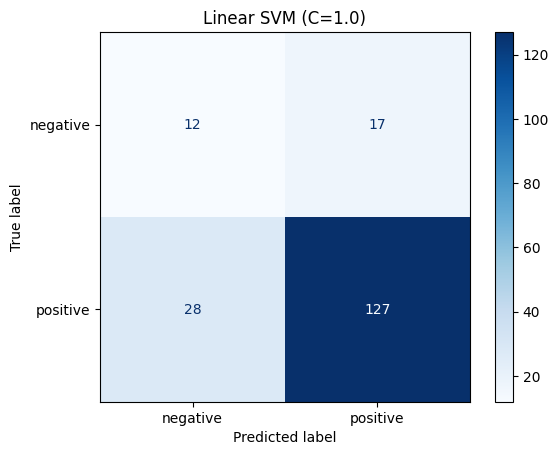

In [ ]:

svm_lin = LinearSVC(
    C=1.0,
    class_weight='balanced',
    random_state=42
)

svm_lin.fit(XTrain1, YTrain1)
YPred_lin = svm_lin.predict(XTest1)
print( classification_report(YTest1, YPred_lin))
display_confusion_matrix(YTest1, YPred_lin, "Linear SVM (C=1.0)", svm_lin)


RBF SVM (C=1.0)
               precision    recall  f1-score   support

    negative       0.21      0.79      0.33        29
    positive       0.92      0.45      0.60       155

    accuracy                           0.50       184
   macro avg       0.57      0.62      0.47       184
weighted avg       0.81      0.50      0.56       184



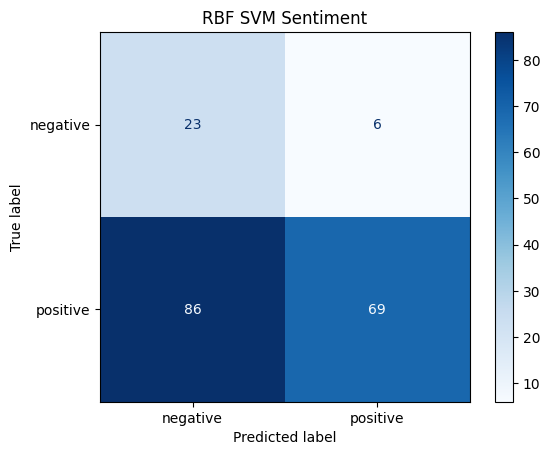

In [118]:
svm_rbf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='auto',
    class_weight='balanced',
    probability=True,
    random_state=42
)
svm_rbf.fit(XTrain1, YTrain1)


YPred_rbf = svm_rbf.predict(XTest1)
print("RBF SVM (C=1.0)\n", classification_report(YTest1, YPred_rbf))
display_confusion_matrix(YTest1, YPred_rbf, "RBF SVM Sentiment", svm_rbf)


              precision    recall  f1-score   support

    negative       0.17      1.00      0.28        29
    positive       1.00      0.06      0.11       155

    accuracy                           0.21       184
   macro avg       0.58      0.53      0.20       184
weighted avg       0.87      0.21      0.14       184



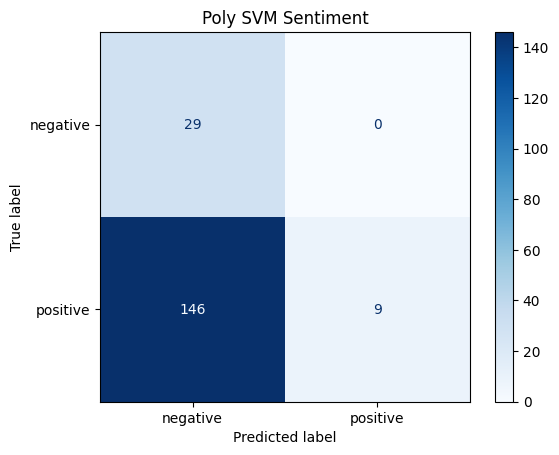

In [128]:

svm_poly = SVC(
    kernel='poly',
    degree=3,
    C=1.0,
    gamma='auto',
    class_weight='balanced',
    probability=True,
    random_state=42
)

svm_poly.fit(XTrain1, YTrain1)

YPred_poly = svm_poly.predict(XTest1)

print( classification_report(YTest1, YPred_poly))
display_confusion_matrix(YTest1, YPred_poly, "Poly SVM Sentiment", svm_poly)

In [ ]:
# that sux so im gonna try and see how it handles the labels
X = dfCV200.drop('LABEL', axis=1)
Y = dfCV200['LABEL']

XTrain, XTest, YTrain, YTest = train_test_split(
    X, Y,
    test_size=0.3,
    random_state=42,
)

svm_lin_topic = LinearSVC(C=1.0, random_state=42)
svm_lin_topic.fit(XTrain, YTrain)
YPred_lin = svm_lin_topic.predict(XTest)

print( classification_report(YTest, YPred_lin))
display_confusion_matrix(YTest, YPred_lin, "Linear SVM C=1.0", svm_lin_topic)

              precision    recall  f1-score   support

       AIart       0.61      0.89      0.73       100
         art       0.74      0.36      0.48        87

    accuracy                           0.64       187
   macro avg       0.68      0.62      0.60       187
weighted avg       0.67      0.64      0.61       187



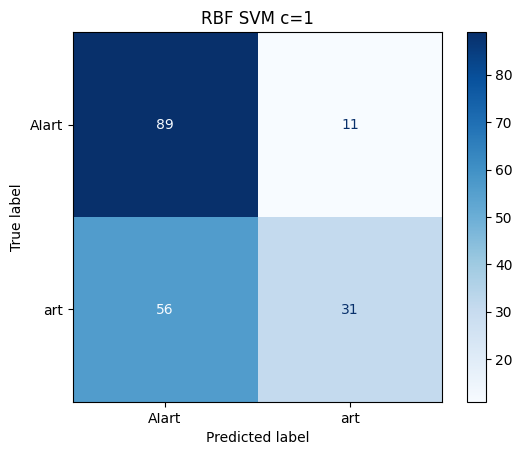

In [115]:
svm_rbf_topic = SVC(
    kernel='rbf',
    C=1.0,
    gamma='auto',
    probability=True,
    random_state=42
)

svm_rbf_topic.fit(XTrain, YTrain)
YPred_rbf = svm_rbf_topic.predict(XTest)


print(classification_report(YTest, YPred_rbf))
display_confusion_matrix(YTest, YPred_rbf, "RBF SVM c=1", svm_rbf_topic)


              precision    recall  f1-score   support

       AIart       0.55      0.99      0.70       100
         art       0.83      0.06      0.11        87

    accuracy                           0.56       187
   macro avg       0.69      0.52      0.41       187
weighted avg       0.68      0.56      0.43       187



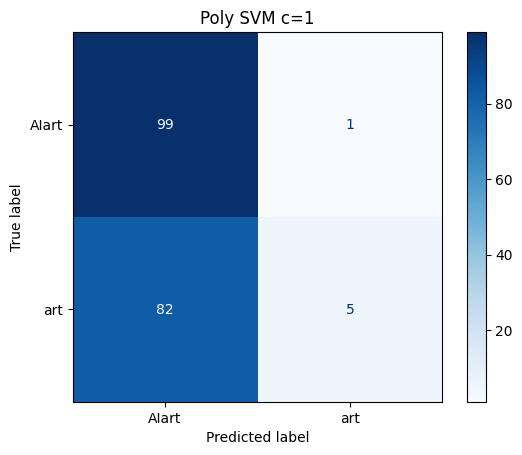

In [ ]:
svm_poly_topic = SVC(
    kernel='poly',
    degree=3,
    C=1.0,
    gamma='auto',
    probability=True,
    random_state=42
)

svm_poly_topic.fit(XTrain, YTrain)
YPred_poly = svm_poly_topic.predict(XTest)


print(classification_report(YTest, YPred_poly))
display_confusion_matrix(YTest, YPred_poly, "Poly SVM c=1", svm_poly_topic)